# Step 1: Data Retrival

To get the data downloaded from the Wikipedia page, we will use the `requests` library to get the HTML of the page. We will use the `BeautifulSoup` library to parse the HTML data and prep it for pandas dfs

In [4]:
import requests
from bs4 import BeautifulSoup
import csv
import re 

url = 'https://en.wikipedia.org/wiki/February_29'

def fetch(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BeautifulSoup(response.content, 'html.parser')
    else:
        print(f"Error fetching the webpage: Status code {response.status_code}")
        return None

def extract_records(soup, heading_id):
    if soup is None:
        return []

    records = []
    id_counter = 1
    heading_span = soup.find("span", {"id": heading_id})
    if not heading_span:
        return records 

    current_element = heading_span.parent 
    while True:
        current_element = current_element.find_next_sibling()
        if not current_element or current_element.name == "h2":
            break 
        if current_element.name == "h3":

            ul = current_element.find_next_sibling("ul")
            if ul:
                for li in ul.find_all("li"):
                    text = li.get_text()
                    try:
                        year, name = text.split('–', 1)
                        year = year.strip()
                        name = re.sub(r'\[\d+\]', '', name) 
                        name = re.sub(r'\(d\.\s*\d+\)', '', name).strip() 
                        records.append({'id': id_counter, 'name': name, 'year': year})
                        id_counter += 1
                    except ValueError:
                        continue
    return records



def save_to_csv(records, filename):
    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['id', 'name', 'year'])
        writer.writeheader()
        for record in records:
            writer.writerow(record)

soup = fetch(url)
births = extract_records(soup, 'Births')
deaths = extract_records(soup, 'Deaths')
save_to_csv(births, 'births.csv')
save_to_csv(deaths, 'deaths.csv')
print("Births and deaths have been saved to 'births.csv' and 'deaths.csv'")

Births and deaths have been saved to 'births.csv' and 'deaths.csv'


# Step 2: Pandas Dataframes

We will use the `pandas` library to create a dataframe from the parsed data and drop nas

In [5]:
import pandas as pd

births_df = pd.read_csv('./births.csv')
deaths_df = pd.read_csv('./deaths.csv')

births_df['year'] = pd.to_datetime(births_df['year'], format='%Y', errors='coerce')
deaths_df['year'] = pd.to_datetime(deaths_df['year'], format='%Y', errors='coerce')

births_df = births_df.dropna(subset=['year'])
deaths_df = deaths_df.dropna(subset=['year'])

births_df['year'] = births_df['year'].dt.year
deaths_df['year'] = deaths_df['year'].dt.year

births_count = births_df.groupby('year').size()
deaths_count = deaths_df.groupby('year').size()


# Step 3: Plot
Here we use matplotlib to create the diagram.

## Nuances:
Since I found no equivalent for ggplots `ggdist:stat_dots` this was a bit more challenging than I initially expected. Alas I am relatively happy with the outcome as it is.
I was not able to add in the respective colors for births and deaths in the title as matplotlibs suptitle does not support this... Theoretically there would be a way using LaTeX, however I opted against this. Another thing I was not able to remove was the Gap in the Y-Axis between the red and green dots...


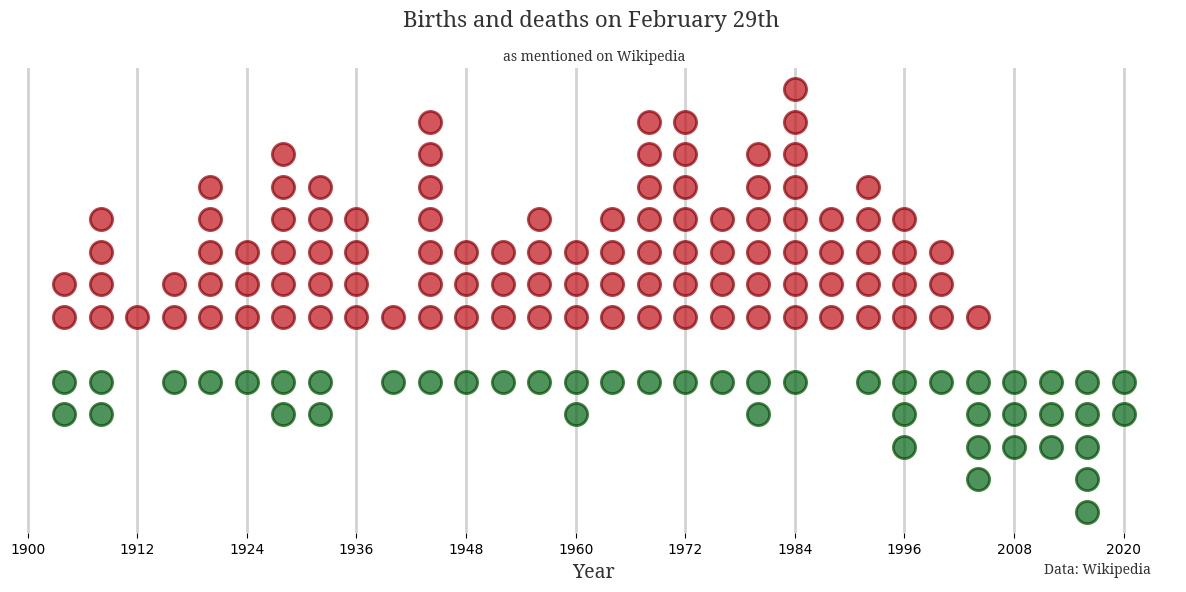

In [131]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import numpy as np

start_year = 1900
end_year = 2020
font_path = './NotoSerif.ttf'
font_props = FontProperties(fname=font_path)


def plot_data(ax, data, color, edge_color, marker_sign):
    for year, count in data.items():
        if start_year <= year <= end_year:
            y_values = marker_sign * np.arange(1, count + 1)
            ax.plot([year] * count, y_values, 'o', color=color, markersize=16, alpha=0.7, markeredgewidth=edge_linewidth, markeredgecolor=edge_color
                    )


# Plot Settings
edge_linewidth = 2
color_births = "#bf1019"
edge_color_births = '#8c0007'
color_deaths = "#056517"
edge_color_deaths = '#004d00'
marker_sign_births = 1  # Positive y-values for births
marker_sign_deaths = -1  # Negative y-values for deaths
figsize = (12, 6)
xlabel_fontsize = 14
title_fontsize = 16
text_color = '#333333'
x_ticks_interval = 12
grid_color = "lightgray"
grid_linestyle = "-"
grid_linewidth = 2

# Create the figure and Axes object
fig, ax = plt.subplots(figsize=figsize)

# Plot the data
plot_data(ax, births_count, color_births, edge_color_births, marker_sign_births)
plot_data(ax, deaths_count, color_deaths, edge_color_deaths, marker_sign_deaths)

# Set labels and title
ax.set_xlabel('Year', fontsize=xlabel_fontsize, color=text_color, fontproperties=font_props)
plt.suptitle('Births and deaths on February 29th', fontsize=title_fontsize, color=text_color, fontproperties=font_props)
plt.title('as mentioned on Wikipedia', color=text_color, fontproperties=font_props)

# Remove y-ticks
ax.set_yticks([])

# Set x-ticks
end_year = max(births_count.keys()[-1], deaths_count.keys()[-1])
ax.set_xticks(range(start_year, end_year + 1, x_ticks_interval))

# Turn off the frame
ax.set(frame_on=False)

# Add grid to the x-axis
ax.grid(axis="x", color=grid_color, linestyle=grid_linestyle, linewidth=grid_linewidth)

# Add Text to the bottom right saying that the data is from Wikipedia
plt.text(end_year -1, -7, 'Data: Wikipedia', ha='right', va='bottom', color=text_color, fontproperties=font_props)

plt.tight_layout()
plt.show()
